In [10]:
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, jmat,tensor, sigmax, sigmay, sigmaz, qeye, mesolve
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
import h5py

def floquet_modes_phtr(H, T, args=None, parallel=False, sort=False, U=None):
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      
    H0 = kn * sz **2 
    H1 = 2 * sx 
    return H0,H1
    
def drive_exact(t, args):
    h0 = args['h0']
    w = args['omega']
    h = args['h']
    return h0 + h * np.cos(w * t)

def floq_evolv_exact(args):
    w = args['omega']
    T = 2 * np.pi/w
    N = args['N']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive_exact]]
    f_modes_0, f_energies = floquet_modes_phtr(H, T, args=args)
    return [w, f_modes_0, f_energies]

print('definition done!')

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.special import jn_zeros, j0
import math, tqdm
from qutip import Options
#from functions_needed import*
import h5py, time

freezing_pts = jn_zeros(0, 5)
start = time.time()

#Ns = [10,20,30,50, 100,150]
#ostp = [1e4,1e5,1e6,1e7,1e11, 1e14]

Ns = [50]
ostp = [1e6]

ws1 = np.exp(np.linspace(np.log(1), np.log(20), 8))
ws2 = np.exp(np.linspace(np.log(22), np.log(90), 8))
ws = np.concatenate((ws1, ws2))
h0 = np.pi/32

nth = 0
frz_nth = 0

if __name__ == '__main__':
    nprocs = 8 
    
    for nn,N in tqdm.tqdm(enumerate(Ns)):
        start1 = time.time()
        opts = Options(nsteps = ostp[nn])        

        params = [{'h0':h0, 'h': w/4 * freezing_pts[frz_nth], 'omega':w, 'N':N, 'opts':opts} for w in ws]
        p = Pool(processes = nprocs)  

        data = np.array(p.map(floq_evolv_exact,params))
        w_f = np.array(data[:,0])
        evec_ff = np.array(data[:,1])
        phs_f = np.array(data[:,2])

        evec_f = np.array([np.array([np.array(evec_ff[j][i])[:,0].real for i in range(int(2*N+1))]) for j in range(len(ws))])

        evals_single_path = np.zeros(len(ws))
        iprmat_single_path = np.zeros(len(ws))
        iprmat = np.zeros((len(ws),2*N+1))

        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,w in enumerate(ws):
            #Get the previous Floquet Eigensystem
            if xx == 0:
                evals_prev = phs_f[xx].real
                evecs_prev = evec_f[xx]
            else:
                evals_prev = phs_f[xx-1].real
                evecs_prev = evec_f[xx-1]

            #Sort the Floquet states of this itertaion accordingly to orthonormality with the previous ones
            evals_curr = phs_f[xx]
            evecs_curr = evec_f[xx]
            #t = np.copy(evecs_curr)
            condition = np.abs(np.around(evecs_prev.T.conj() @ evecs_curr, 1))   
            evals_curr = evals_curr[np.argmax(condition, axis=1)]
            evecs_curr = evecs_curr[:,np.argmax(condition, axis=1)]

            evals_single_path[xx] = evals_curr[nth]

            f_states = evec_f[xx]
            iprmat[xx,:] = [np.sum([np.abs(Qobj(state).overlap(sx_ev))**4 for sx_ev in st], axis=-1) for state in f_states]
            iprmat_single_path[xx] = iprmat[xx,:][nth]

            # save the data
        filename = 'phase_transition_singleparthamN_bigger_nsteps_' + str(N) +'_.hdf5'

        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('ws', np.shape(ws), data=ws)
            hf.create_dataset('iprmat_single_path', np.shape(iprmat_single_path), data=iprmat_single_path)
            hf.create_dataset('evals_single_path', np.shape(evals_single_path), data=evals_single_path)
            hf.attrs['N'] = N
            hf.attrs['dc'] = h0
        print('time taken %5.1f  minutes !'% ((time.time()-start1)/60))
    print('\n\n\n Code Run Complete!! \n\n TOTAL TIME TAKEN : %5.1f  minutes !' %((time.time()-start)/60))

definition done!


0it [00:00, ?it/s]/tmp/ipykernel_5055/2694964412.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(p.map(floq_evolv_exact,params))
1it [00:54, 54.89s/it]

time taken   0.9  minutes !



 Code Run Complete!! 

 TOTAL TIME TAKEN :   0.9  minutes !


In [11]:
!ls phase_transition_singleparthamN_bigger_nsteps_* > file_phasetran.txt
!cat file_phasetran.txt

phase_transition_singleparthamN_bigger_nsteps_30_.hdf5
phase_transition_singleparthamN_bigger_nsteps_50_.hdf5


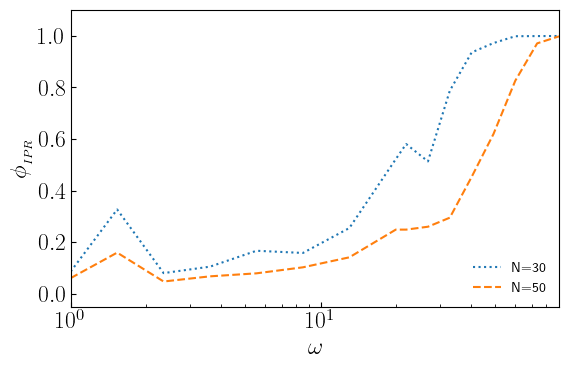

CPU times: user 218 ms, sys: 8.02 ms, total: 226 ms
Wall time: 237 ms


In [12]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (6, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 17, "font.sans-serif": ["Computer Modern"]})


with open("file_phasetran.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    j =0
    
    linest = ['dotted', 'dashed', 'dashdot','solid']
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)
            plt.plot(ws, iprmat_single_path, label = lbl, linestyle= linest[i] )
                
plt.ylabel(r"$\phi_{{_{{IPR}}}}$")
plt.xlabel(r"$\omega$")
plt.ylim(-0.05,1.1)
plt.xlim(1,ws[-1])
plt.xscale('log')

figname= "phase_dynam1.jpeg" 

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.tight_layout()
plt.legend(frameon = False, loc = 4,fontsize= 10)
#plt.savefig(figname,dpi=600)
plt.show()